# Chapter 4: Bayesian Statistics in pymc3 (Working in progress proof of concept)

In [5]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp


# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

In [6]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000-10000,747000 + 20600,6863000 - 20600,6950000 + 20600,
                           -20000, 600], [30,30,30],
                        path_o = os.pardir+"/input_data/tut_SandStone/SandStone_Foliations.csv",
                        path_i = os.pardir+"/input_data/tut_SandStone/SandStone_Points.csv")

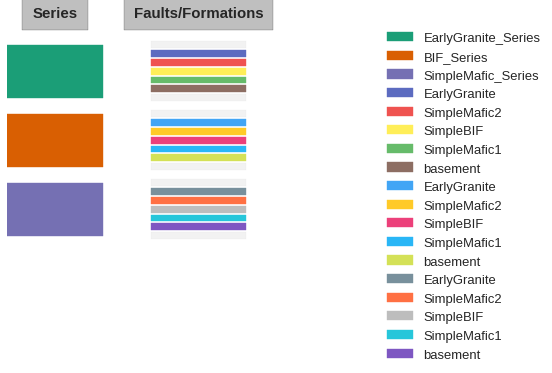

In [7]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                              "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

In [4]:
geo_data.set_formation_values([2.61, 2.92, 3.1, 2.91, 2.61])

I am changing formations3


In [5]:
geo_data.formations

,value,formation_number
EarlyGranite,2.61,1
SimpleMafic2,2.92,2
SimpleBIF,3.10,3
SimpleMafic1,2.91,4
basement,2.61,5


In [6]:
geo_data.update_df()

there
1


Setting uncertainties adding the values to the Dataframe.

In [7]:
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = 0
geo_data.interfaces['Z_std'] = 100

geo_data.orientations['X_std'] = None
geo_data.orientations['Y_std'] = 0
geo_data.orientations['Z_std'] = 100

geo_data.orientations['dip_std'] = 10
geo_data.orientations['azimuth_std'] = 10
geo_data.orientations.head()

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,...,formation_number,order_series,isFault,annotations,formation_value,X_std,Y_std,Z_std,dip_std,azimuth_std
0,732683.4690,6882332.75,481.711952,0.310842,-0.934464,0.173648,80.0,161.600709,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},0}$",2.61,None,0,100,10,10
1,730627.5315,6880472.50,477.402658,0.844266,-0.507012,0.173648,80.0,120.986348,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},1}$",2.61,None,0,100,10,10
2,728767.4065,6878759.25,470.031623,0.238570,-0.955474,0.173648,80.0,165.980598,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},2}$",2.61,None,0,100,10,10
3,728571.5940,6879934.25,472.536776,-0.862410,0.475494,0.173648,80.0,298.870347,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},3}$",2.61,None,0,100,10,10
4,729256.9065,6882724.50,471.722924,-0.982254,-0.070879,0.173648,80.0,265.872737,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},4}$",2.61,None,0,100,10,10


## Real gravity

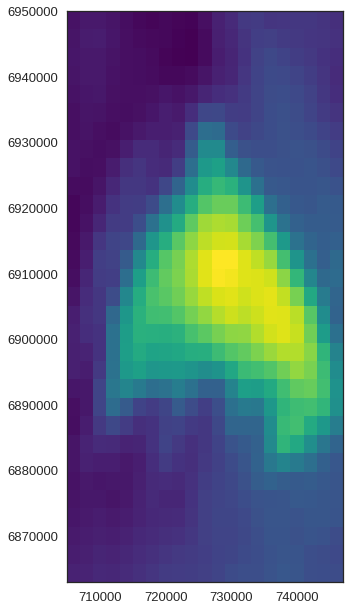

In [8]:
import matplotlib.pyplot as plt
import pandas as pn
grav_real = pn.read_csv('../input_data/tut_SandStone/Sst_grav_2000.xyz', header=None, names = ['X', 'Y', 'N', 'G'], delim_whitespace=True)
plt.imshow(grav_real['G'].values.reshape(31,21), extent=[7.050000e+05,747000,6863000,6950000], origin='lower', cmap='viridis')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [9]:
# Calibration parameters
# F_min, F_max =  np.min(Forw), np.max(Forw)   #36.630742, 36.651496    #30.159309, 30.174104#
# F_range = F_max - F_min
# F_mid = 0.5*(F_max+F_min)

rs_min, rs_max = np.min(grav_real['G']), np.max(grav_real['G'])
rs_range = rs_max - rs_min
rs_mid = 0.5*(rs_max+rs_min)

#Rescaling

# rs_mid + (grid - m_mid) / m_range * rs_range
# Reescaled_forw = rs_mid + (Forw - F_mid) / F_range * rs_range

In [10]:
import theano
grav_real_mid = theano.shared(rs_mid, 'Grav_real_mid')
grav_real_range = theano.shared(rs_range, 'Grav_real_range')
grav_real_th = theano.shared(grav_real['G'].as_matrix())

In [11]:
grav_real_th.get_value().shape

(651,)

In [12]:
# input_data_T = interp_data.interpolator.tg.input_parameters_list()
# input_data_P = interp_data.get_input_data(u_grade=[3, 3])
# select = interp_data.interpolator.pandas_rest_layer_points['formation'] == 'Reservoir'

In [26]:
interp_data_grav = gp.InterpolatorData(geo_data, output='gravity',
                                       compile_theano=False, dtype='float64',
                                       theano_optimizer='fast_compile',
                                       u_grade=[1,1,1], verbose=[])

gp.set_geophysics_obj(interp_data_grav,  [7.050000e+05,747000,6863000,6925000,-20000, 200],
                                             [31,21])

gp.precomputations_gravity(interp_data_grav, 25, 
                           [2.92, 3.1, 2.92, 2.61, 2.61])

(array([[  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        ..., 
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05]]),
 array([False, False, False, ..., False, False, False], dtype=bool))

In [14]:
interp_data_grav.geo_data_res.x_to_interp_given

array([[ 0.31239727,  0.26427238,  0.43420065],
       [ 0.31239727,  0.26427238,  0.43875562],
       [ 0.31239727,  0.26427238,  0.44331059],
       ..., 
       [ 0.83564421,  1.08633658,  0.55718491],
       [ 0.83564421,  1.08633658,  0.56173988],
       [ 0.83564421,  1.08633658,  0.56629485]])

In [15]:
#a,b = gp.precomputations_gravity(interp_data_grav, 24, [2.92, 3.1, 2.92, 2.61, 2.61])

In [16]:
#sol[0][1]

In [17]:
#theano.config.compute_test_value = 'off'

sol = gp.compute_model(interp_data_grav, output='gravity')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l __str__ = 24.758758544921875
b __str__ = 23.79234504699707
a __str__ = 24.336517333984375
n_formation __str__ = 2.61
b __str__ = 22.31702995300293
a __str__ = 23.79234504699707
n_formation __str__ = 2.92
max_pot __str__ = 21.354501724243164
min_pot __str__ = 20.911487579345703
l __str__ = 113.2963638305664
b __str__ = 21.33236312866211
a __str__ = 21.354501724243164
n_formation __str__ = 2.92
b __str__ = 21.328975677490234
a __str__ = 21.33236312866211
n_formation __str__ = 3.1
b __str__ = 20.911487579345703
a __str__ = 21.328975677490234
n_formation __str__ = 2.91
max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.8521327972

[[ 2.60999658  2.60999876  2.60999969  2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.61        2.60999969
   2.60999907  2.60999627  2.60998631]
 [ 2.60999751  2.60999907  2.60999969  2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.61        2.60999969
   2.60999938  2.6099972   2.60999004]
 [ 2.60999813  2.60999938  2.60999969  2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.61        2.61        2.61
   2.61        2.61        2.61        2.61        2.6

<IPython.core.display.Javascript object>


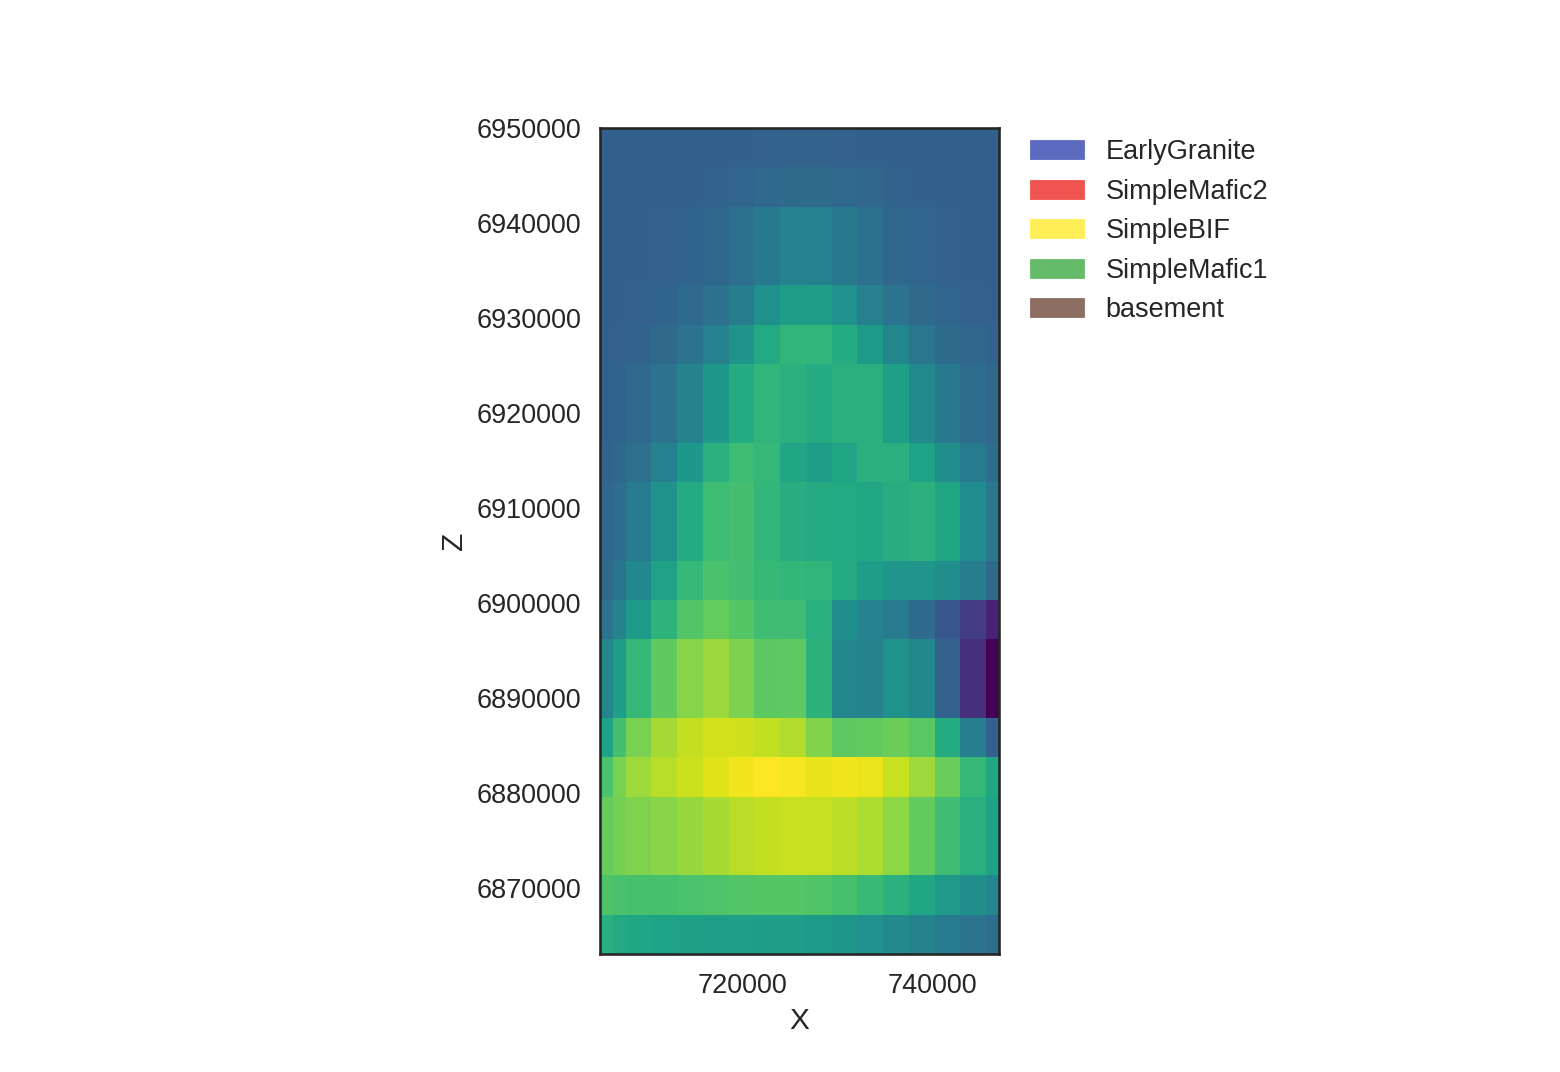

In [18]:
%matplotlib notebook
gp.plot.plot_section(geo_data, sol[0][0], 20)

In [19]:
plt.imshow(sol[2].reshape(21,31), cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000] )


Now the generation of the geomodel will be an operation embedded in a larger tree.

In [28]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph(interp_data_grav.interpolator.tg.input_parameters_list(),
                              [interp_data_grav.interpolator.tg.compute_forward_gravity(0)[-1]],
                              on_unused_input='ignore',
                            )

In [29]:
input_sh = []
for i in interp_data_grav.get_input_data():
    input_sh.append(theano.shared(i))

In [30]:
input_sh

[<TensorType(float64, matrix)>,
 <TensorType(float64, vector)>,
 <TensorType(float64, vector)>,
 <TensorType(float64, vector)>,
 <TensorType(float64, matrix)>,
 <TensorType(float64, matrix)>]

In [31]:
e = geomodel(*input_sh)
der = theano.grad(e.sum(), input_sh[-3])

In [34]:
a = theano.function(interp_data_grav.interpolator.tg.input_parameters_list(), [der], on_unused_input='ignore')

In [37]:
a(*interp_data_grav.get_input_data())

max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l __str__ = 24.758758544921875
b __str__ = 23.79234504699707
a __str__ = 24.336517333984375
n_formation __str__ = 2.61
b __str__ = 22.31702995300293
a __str__ = 23.79234504699707
n_formation __str__ = 2.92
max_pot __str__ = 21.354501724243164
min_pot __str__ = 20.911487579345703
l __str__ = 113.2963638305664
b __str__ = 21.33236312866211
a __str__ = 21.354501724243164
n_formation __str__ = 2.92
b __str__ = 21.328975677490234
a __str__ = 21.33236312866211
n_formation __str__ = 3.1
b __str__ = 20.911487579345703
a __str__ = 21.328975677490234
n_formation __str__ = 2.91
max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61
max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l 

[array([  3.53617417e-01,   3.46782612e-03,  -1.50671486e+00,
          8.02098449e-01,   1.79289963e-01,   2.55987152e+00,
          1.28932468e+00,   2.33693586e-01,  -1.02241372e+00,
          4.32072731e-01,   2.22127955e+00,   4.92091559e-01,
         -6.51083297e+00,  -3.02985215e+00,  -8.63316508e-01,
          4.55514658e+00,   1.67889876e+00,   1.23521240e+00,
         -1.87947056e+00,  -2.01176408e-01,  -4.93693904e-01,
          2.29424213e+00,  -5.72574904e-02,   4.41213241e-02,
          2.81417210e-01,  -3.09125819e+00,   1.90648602e+01,
         -1.90643015e+01,  -2.42822859e+00,  -4.27954921e+01,
          2.33834230e+01,   1.35344108e+00,   6.00007780e+00,
         -4.75697912e+00,  -1.08697135e+01,  -7.87725979e+00,
          2.48274590e+01,   3.68616710e+00,   8.81238874e+00,
         -4.64681374e-01,   1.12978029e+00])]

max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l __str__ = 24.758758544921875
b __str__ = 23.79234504699707
a __str__ = 24.336517333984375
n_formation __str__ = 2.61
b __str__ = 22.31702995300293
a __str__ = 23.79234504699707
n_formation __str__ = 2.92
max_pot __str__ = 21.354501724243164
min_pot __str__ = 20.911487579345703
l __str__ = 113.2963638305664
b __str__ = 21.33236312866211
a __str__ = 21.354501724243164
n_formation __str__ = 2.92
b __str__ = 21.328975677490234
a __str__ = 21.33236312866211
n_formation __str__ = 3.1
b __str__ = 20.911487579345703
a __str__ = 21.328975677490234
n_formation __str__ = 2.91
max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


<IPython.core.display.Javascript object>


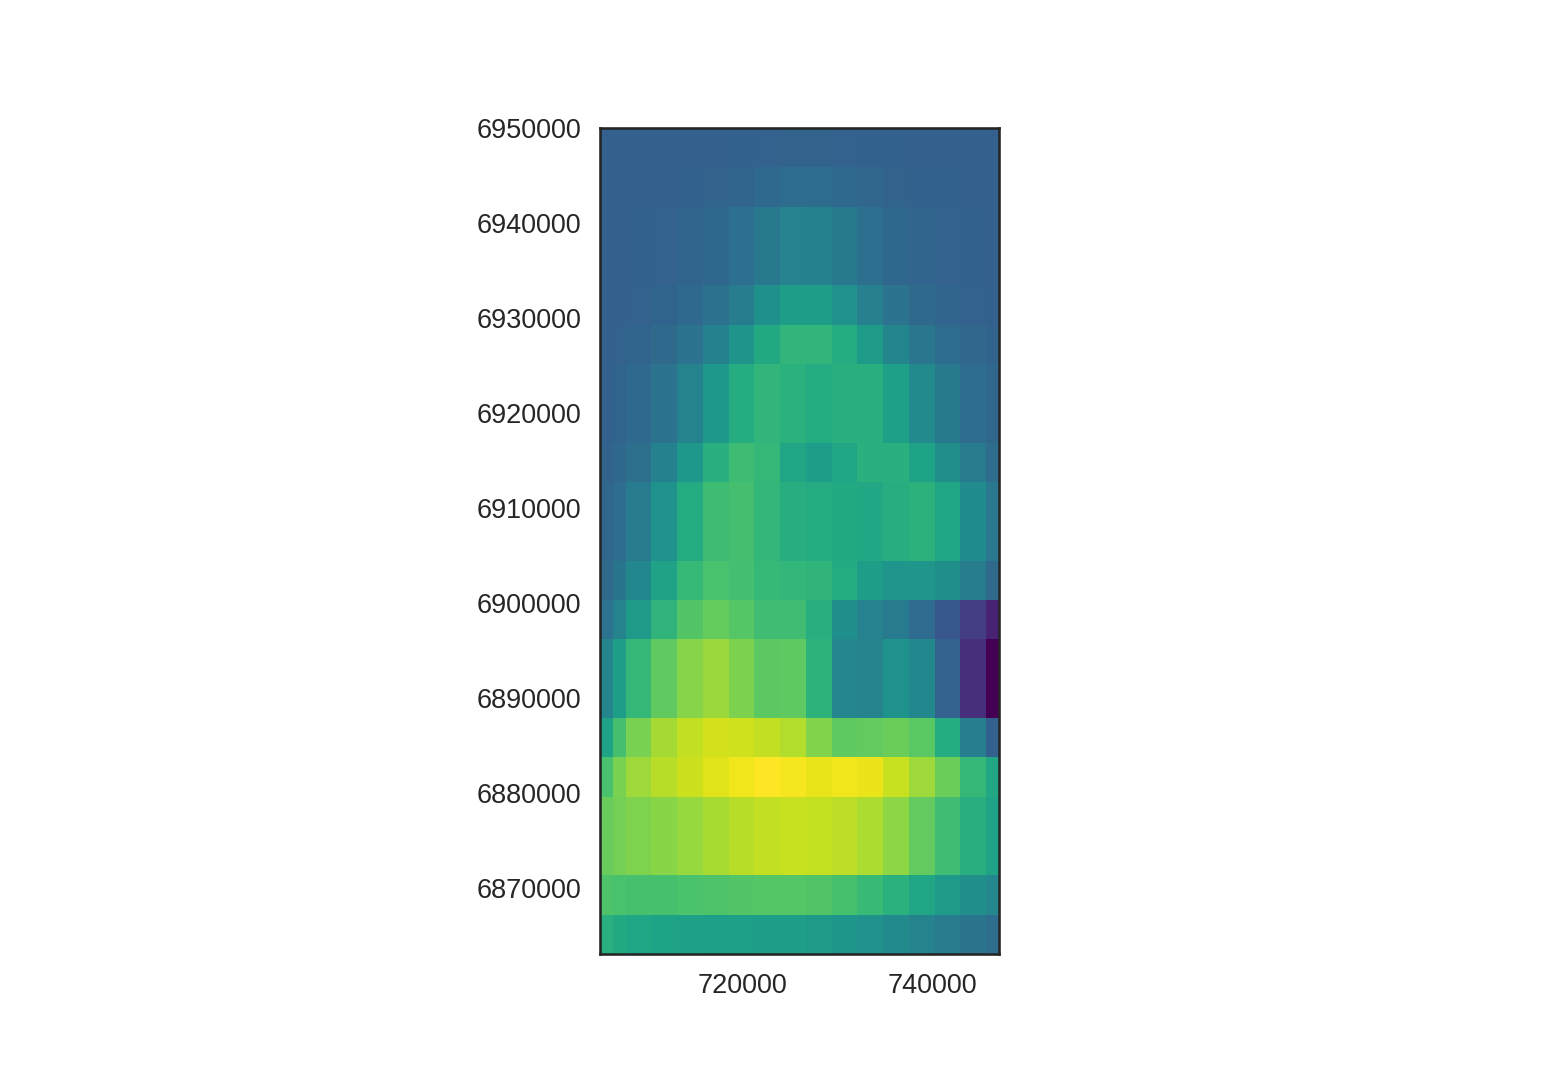

In [33]:
plt.imshow(a(*interp_data_grav.get_input_data())[0].reshape(21,31), cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000] )



Because now the GeMpy model is a theano operation and not a theano function, to call it we need to use theano variables (with theano functions we call them with python variables). This is very easy to modify, we just need to use theano shared to convert our python input data into theano variables.

The pymc3 objects are already theano variables (pm.Normal and so on). Now the trick is that using the theano function T.set_subtensor, we can change one deterministic value of the input arrays(the ones printed in the cell above) by a stochastic pymc3 object. Then with the new arrays we just have to call the theano operation and pymc will do the rest

In [39]:
# This is the creation of the model
import pymc3 as pm

theano.config.compute_test_value = 'warn'
dtype='float64'
#theano.config.warn_float64 = 'warn'
model = pm.Model()
with model:
    # We create the Stochastic parameters. In this case only the Z position
    # of the interfaces
    Z_rest = pm.Normal('Z_unc_rest',
       interp_data_grav.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
       interp_data_grav.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'),
                  dtype=dtype, shape = (66))
    
    Z_ref = pm.Normal('Z_unc_ref', interp_data_grav.interpolator.pandas_ref_layer_points_rep['Z'].as_matrix().astype('float32'),
              interp_data_grav.interpolator.pandas_ref_layer_points_rep['Z_std'].as_matrix().astype('float32'),
              dtype=dtype, shape = (66))
    
    dip_unc = pm.Normal('dip_unc', interp_data_grav.geo_data_res.orientations['dip'].as_matrix(),
                        interp_data_grav.geo_data_res.orientations['dip_std'].as_matrix(),
                       dtype=dtype, shape = (41))
    
    azimuth_unc = pm.Normal('azimuth_unc', interp_data_grav.geo_data_res.orientations['azimuth'].as_matrix(), 
                            interp_data_grav.geo_data_res.orientations['azimuth_std'].as_matrix(),
                       dtype=dtype, shape = (41))
    
#     Z_unc = pm.Normal('Z_unc', interp_data_grav.geo_data_res.interfaces['Z'].astype('float32'),
#                       interp_data_grav.geo_data_res.interfaces['Z_std'].astype('float32'), dtype='float32', shape= (70))
    
#     interp_data_grav.geo_data_res.interfaces['Z'] = Z_unc
    
    # We convert a python variable to theano.shared
    input_sh = []
    for i in interp_data_grav.get_input_data():
        input_sh.append(theano.shared(i))
    
    # We add the stochastic value to the correspondant array. rest array is
    # a n_points*3 (XYZ) array. We only want to change Z in this case.
    input_sh[4] = T.set_subtensor(
    input_sh[4][:, 2], Z_ref)

    input_sh[5] = T.set_subtensor(
    input_sh[5][:, 2], Z_rest)
    
    # With the stochastic parameters we create the geomodel result:
    Forw = pm.Deterministic('GemPy', geomodel(input_sh[0], input_sh[1], input_sh[2],
                                                   input_sh[3], input_sh[4], input_sh[5]))
    
    # Calibration parameters
    F_min, F_max =  T.min(Forw), T.max(Forw)   #36.630742, 36.651496    #30.159309, 30.174104#
    F_range = F_max - F_min
    F_mid = 0.5*(F_max+F_min)
    
    Reescaled_forw = grav_real_mid + (Forw - F_mid) / F_range * grav_real_range
    
    e_sq = T.sqrt(T.sum(T.square(Reescaled_forw - (grav_real_th))))

    Y_obs = pm.HalfCauchy('Y_obs', beta=e_sq, observed=1000)

max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l __str__ = 24.758758544921875
b __str__ = 23.79234504699707
a __str__ = 24.336517333984375
n_formation __str__ = 2.61
b __str__ = 22.31702995300293
a __str__ = 23.79234504699707
n_formation __str__ = 2.92
max_pot __str__ = 21.354501724243164
min_pot __str__ = 20.911487579345703
l __str__ = 113.2966079711914
b __str__ = 21.332365036010742
a __str__ = 21.354501724243164
n_formation __str__ = 2.92
b __str__ = 21.328975677490234
a __str__ = 21.332365036010742
n_formation __str__ = 3.1
b __str__ = 20.911487579345703
a __str__ = 21.328975677490234
n_formation __str__ = 2.91
max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


In [ ]:
#import theano.tensor as T
#import pymc3 as pm
#pm.HalfCauchy?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l __str__ = 24.758758544921875
b __str__ = 23.79234504699707
a __str__ = 24.336517333984375
n_formation __str__ = 2.61
b __str__ = 22.31702995300293
a __str__ = 23.79234504699707
n_formation __str__ = 2.92
max_pot __str__ = 21.354501724243164
min_pot __str__ = 20.911487579345703
l __str__ = 113.2966079711914
b __str__ = 21.332365036010742
a __str__ = 21.354501724243164
n_formation __str__ = 2.92
b __str__ = 21.328975677490234
a __str__ = 21.332365036010742
n_formation __str__ = 3.1
b __str__ = 20.911487579345703
a __str__ = 21.328975677490234
n_formation __str__ = 2.91
max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61
max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l

  0%|          | 0/40 [00:00<?, ?it/s]

max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l __str__ = 24.758758544921875
b __str__ = 23.79234504699707
a __str__ = 24.336517333984375
n_formation __str__ = 2.61
b __str__ = 22.31702995300293
a __str__ = 23.79234504699707
n_formation __str__ = 2.92
max_pot __str__ = 21.354501724243164
min_pot __str__ = 20.911487579345703
l __str__ = 113.2966079711914
b __str__ = 21.332365036010742
a __str__ = 21.354501724243164
n_formation __str__ = 2.92
b __str__ = 21.328975677490234
a __str__ = 21.332365036010742
n_formation __str__ = 3.1
b __str__ = 20.911487579345703
a __str__ = 21.328975677490234
n_formation __str__ = 2.91
max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61
max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298828

max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l __str__ = 24.758758544921875
b __str__ = 23.79234504699707
a __str__ = 24.336517333984375
n_formation __str__ = 2.61
b __str__ = 22.31702995300293
a __str__ = 23.79234504699707
n_formation __str__ = 2.92
max_pot __str__ = 21.354501724243164
min_pot __str__ = 20.911487579345703
l __str__ = 113.2966079711914
b __str__ = 21.332365036010742
a __str__ = 21.354501724243164
n_formation __str__ = 2.92
b __str__ = 21.328975677490234
a __str__ = 21.332365036010742
n_formation __str__ = 3.1
b __str__ = 20.911487579345703
a __str__ = 21.328975677490234
n_formation __str__ = 2.91
max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


<IPython.core.display.Javascript object>


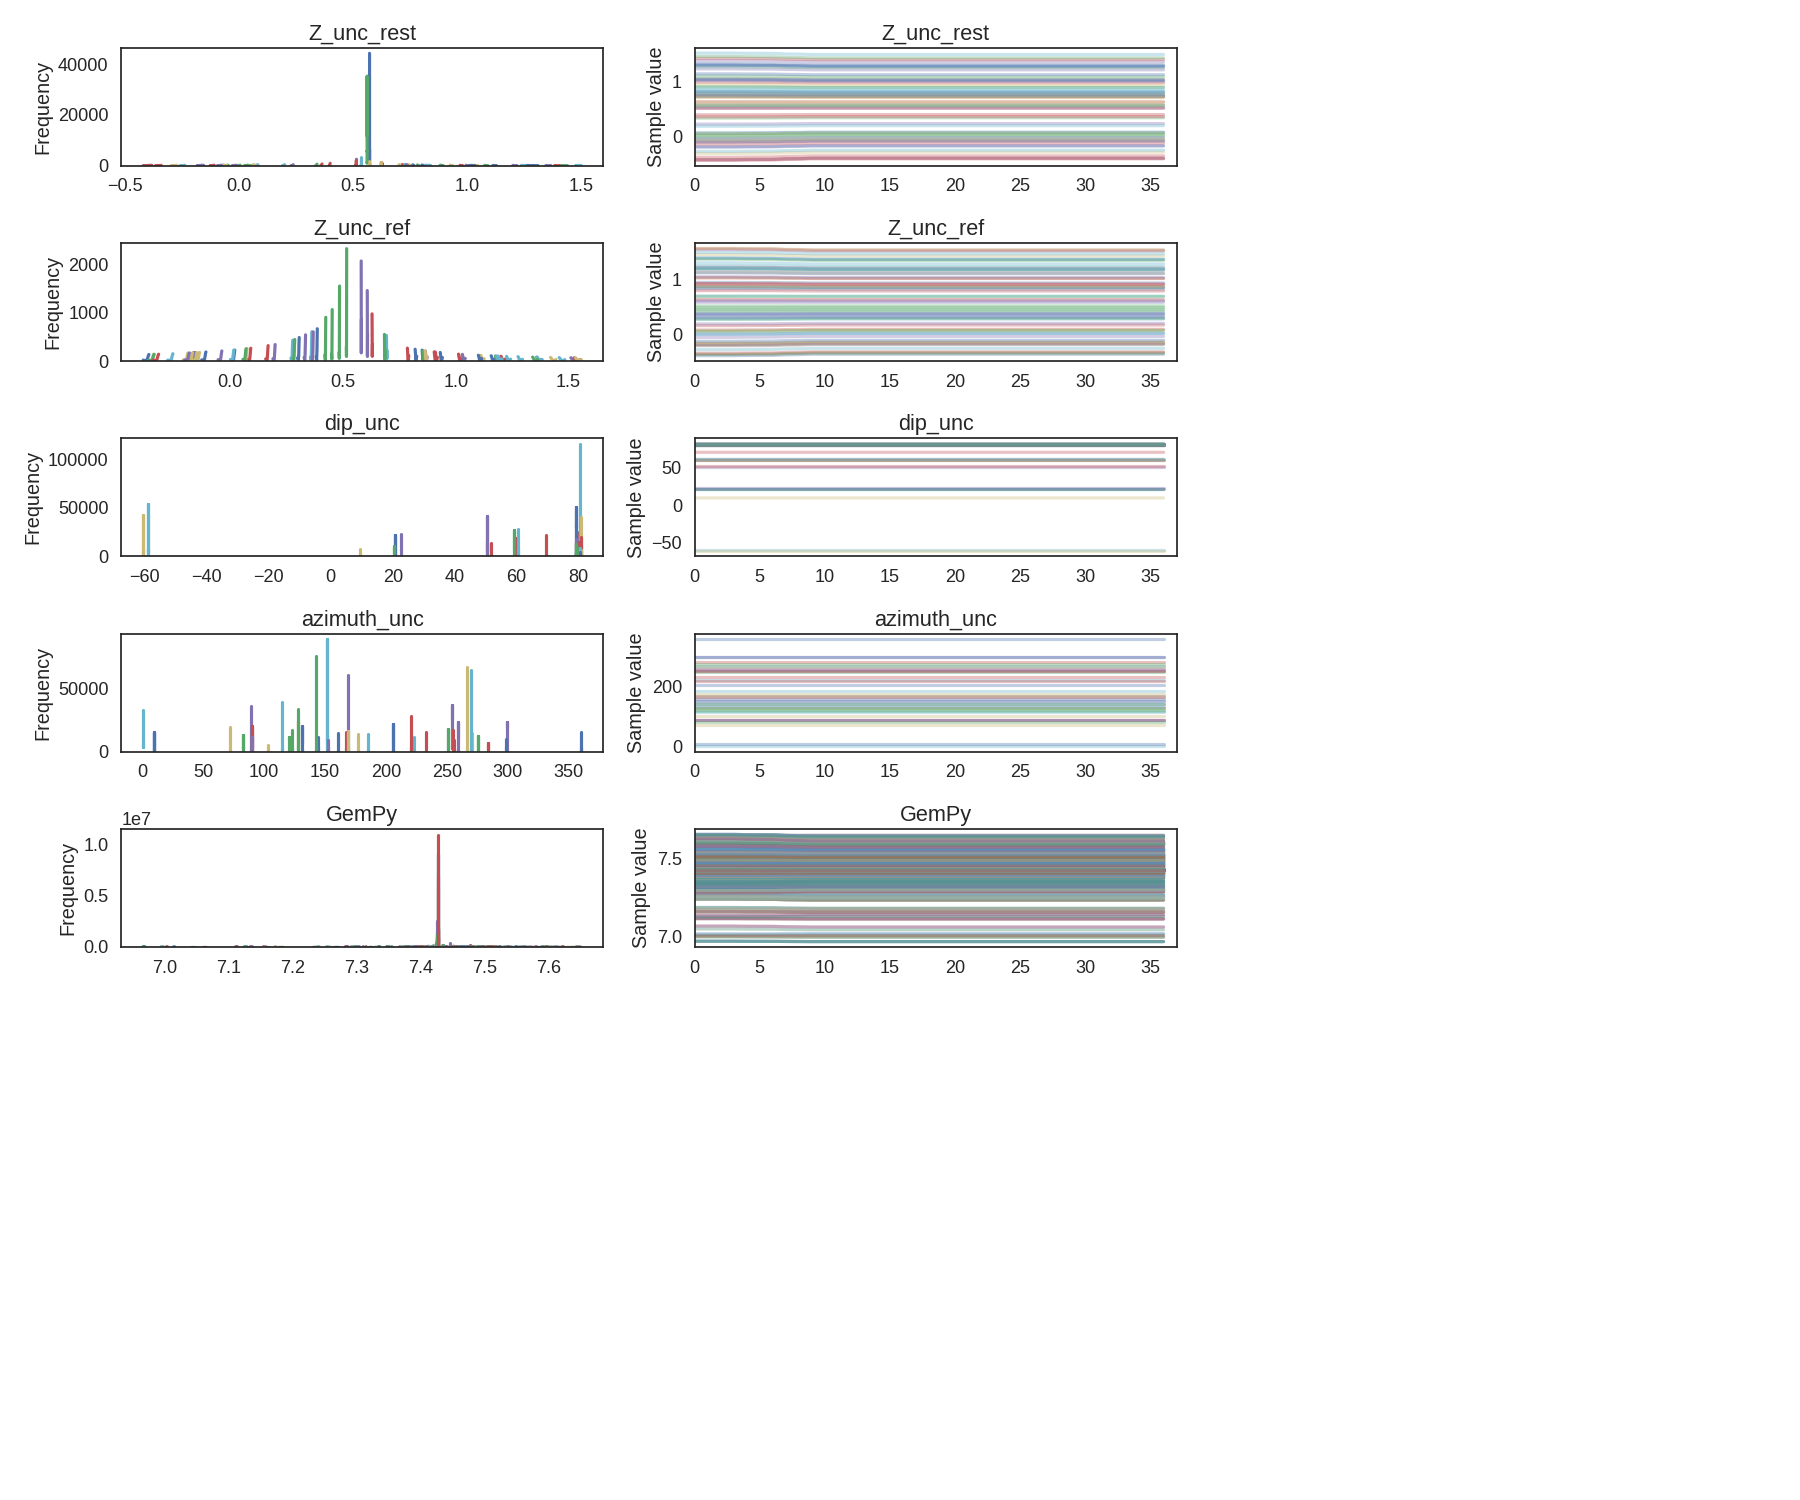

  2%|▎         | 1/40 [00:14<09:21, 14.39s/it]

max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298828
l __str__ = 50.675724029541016
b __str__ = 23.87030792236328
a __str__ = 24.224111557006836
n_formation __str__ = 2.61
b __str__ = 23.237445831298828
a __str__ = 23.87030792236328
n_formation __str__ = 2.92
max_pot __str__ = 20.946123123168945
min_pot __str__ = 20.562789916992188
l __str__ = 127.65499114990234
b __str__ = 20.88325309753418
a __str__ = 20.946123123168945
n_formation __str__ = 2.92
b __str__ = 20.899948120117188
a __str__ = 20.88325309753418
n_formation __str__ = 3.1
b __str__ = 20.562789916992188
a __str__ = 20.899948120117188
n_formation __str__ = 2.91
max_pot __str__ = 20.604145050048828
min_pot __str__ = 19.902908325195312
l __str__ = 71.30259704589844
b __str__ = 20.58989906311035
a __str__ = 20.604145050048828
n_formation __str__ = 2.91
b __str__ = 19.902908325195312
a __str__ = 20.58989906311035
n_formation __str__ = 2.61
max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298

b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


  5%|▌         | 2/40 [00:28<08:54, 14.05s/it]

max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298828
l __str__ = 50.675724029541016
b __str__ = 23.87030792236328
a __str__ = 24.224111557006836
n_formation __str__ = 2.61
b __str__ = 23.237445831298828
a __str__ = 23.87030792236328
n_formation __str__ = 2.92
max_pot __str__ = 20.946123123168945
min_pot __str__ = 20.562789916992188
l __str__ = 127.65499114990234
b __str__ = 20.88325309753418
a __str__ = 20.946123123168945
n_formation __str__ = 2.92
b __str__ = 20.899948120117188
a __str__ = 20.88325309753418
n_formation __str__ = 3.1
b __str__ = 20.562789916992188
a __str__ = 20.899948120117188
n_formation __str__ = 2.91
max_pot __str__ = 20.604145050048828
min_pot __str__ = 19.902908325195312
l __str__ = 71.30259704589844
b __str__ = 20.58989906311035
a __str__ = 20.604145050048828
n_formation __str__ = 2.91
b __str__ = 19.902908325195312
a __str__ = 20.58989906311035
n_formation __str__ = 2.61
max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


  8%|▊         | 3/40 [00:42<08:40, 14.08s/it]

max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298828
l __str__ = 50.675724029541016
b __str__ = 23.87030792236328
a __str__ = 24.224111557006836
n_formation __str__ = 2.61
b __str__ = 23.237445831298828
a __str__ = 23.87030792236328
n_formation __str__ = 2.92
max_pot __str__ = 20.946123123168945
min_pot __str__ = 20.562789916992188
l __str__ = 127.65499114990234
b __str__ = 20.88325309753418
a __str__ = 20.946123123168945
n_formation __str__ = 2.92
b __str__ = 20.899948120117188
a __str__ = 20.88325309753418
n_formation __str__ = 3.1
b __str__ = 20.562789916992188
a __str__ = 20.899948120117188
n_formation __str__ = 2.91
max_pot __str__ = 20.604145050048828
min_pot __str__ = 19.902908325195312
l __str__ = 71.30259704589844
b __str__ = 20.58989906311035
a __str__ = 20.604145050048828
n_formation __str__ = 2.91
b __str__ = 19.902908325195312
a __str__ = 20.58989906311035
n_formation __str__ = 2.61
max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298

 10%|█         | 4/40 [00:56<08:27, 14.10s/it]

max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298828
l __str__ = 50.675724029541016
b __str__ = 23.87030792236328
a __str__ = 24.224111557006836
n_formation __str__ = 2.61
b __str__ = 23.237445831298828
a __str__ = 23.87030792236328
n_formation __str__ = 2.92
max_pot __str__ = 20.946123123168945
min_pot __str__ = 20.562789916992188
l __str__ = 127.65499114990234
b __str__ = 20.88325309753418
a __str__ = 20.946123123168945
n_formation __str__ = 2.92
b __str__ = 20.899948120117188
a __str__ = 20.88325309753418
n_formation __str__ = 3.1
b __str__ = 20.562789916992188
a __str__ = 20.899948120117188
n_formation __str__ = 2.91
max_pot __str__ = 20.604145050048828
min_pot __str__ = 19.902908325195312
l __str__ = 71.30259704589844
b __str__ = 20.58989906311035
a __str__ = 20.604145050048828
n_formation __str__ = 2.91
b __str__ = 19.902908325195312
a __str__ = 20.58989906311035
n_formation __str__ = 2.61
max_pot __str__ = 24.224111557006836
min_pot __str__ = 23.237445831298

max_pot __str__ = 20.61031723022461
min_pot __str__ = 19.906959533691406
l __str__ = 71.08758544921875
b __str__ = 20.5958251953125
a __str__ = 20.61031723022461
n_formation __str__ = 2.91
b __str__ = 19.906959533691406
a __str__ = 20.5958251953125
n_formation __str__ = 2.61
n_formation __str__ = 2.61
b __str__ = 19.906959533691406
a __str__ = 20.5958251953125
n_formation __str__ = 2.91
b __str__ = 20.5958251953125
a __str__ = 20.61031723022461
max_pot __str__ = 20.94447898864746
min_pot __str__ = 20.561887741088867
l __str__ = 127.92691802978516
b __str__ = 20.882369995117188
a __str__ = 20.94447898864746
n_formation __str__ = 2.92
b __str__ = 20.898883819580078
a __str__ = 20.882369995117188
n_formation __str__ = 3.1
b __str__ = 20.561887741088867
a __str__ = 20.898883819580078
n_formation __str__ = 2.91
n_formation __str__ = 2.91
b __str__ = 20.561887741088867
a __str__ = 20.898883819580078
n_formation __str__ = 3.1
b __str__ = 20.898883819580078
a __str__ = 20.882369995117188
n_for

 12%|█▎        | 5/40 [01:15<08:46, 15.04s/it]

max_pot __str__ = 24.22457504272461
min_pot __str__ = 23.237777709960938
l __str__ = 50.66896438598633
b __str__ = 23.870899200439453
a __str__ = 24.22457504272461
n_formation __str__ = 2.61
b __str__ = 23.237777709960938
a __str__ = 23.870899200439453
n_formation __str__ = 2.92
max_pot __str__ = 20.945819854736328
min_pot __str__ = 20.562698364257812
l __str__ = 127.73243713378906
b __str__ = 20.883146286010742
a __str__ = 20.945819854736328
n_formation __str__ = 2.92
b __str__ = 20.899789810180664
a __str__ = 20.883146286010742
n_formation __str__ = 3.1
b __str__ = 20.562698364257812
a __str__ = 20.899789810180664
n_formation __str__ = 2.91
max_pot __str__ = 20.605493545532227
min_pot __str__ = 19.903583526611328
l __str__ = 71.23419952392578
b __str__ = 20.591182708740234
a __str__ = 20.605493545532227
n_formation __str__ = 2.91
b __str__ = 19.903583526611328
a __str__ = 20.591182708740234
n_formation __str__ = 2.61
max_pot __str__ = 24.22457504272461
min_pot __str__ = 23.2377777099

max_pot __str__ = 20.605579376220703
min_pot __str__ = 19.903610229492188
l __str__ = 71.22820281982422
b __str__ = 20.59126091003418
a __str__ = 20.605579376220703
n_formation __str__ = 2.91
b __str__ = 19.903610229492188
a __str__ = 20.59126091003418
n_formation __str__ = 2.61
n_formation __str__ = 2.61
b __str__ = 19.903610229492188
a __str__ = 20.59126091003418
n_formation __str__ = 2.91
b __str__ = 20.59126091003418
a __str__ = 20.605579376220703
max_pot __str__ = 20.945741653442383
min_pot __str__ = 20.562639236450195
l __str__ = 127.738037109375
b __str__ = 20.88307762145996
a __str__ = 20.945741653442383
n_formation __str__ = 2.92
b __str__ = 20.89972496032715
a __str__ = 20.88307762145996
n_formation __str__ = 3.1
b __str__ = 20.562639236450195
a __str__ = 20.89972496032715
n_formation __str__ = 2.91
n_formation __str__ = 2.91
b __str__ = 20.562639236450195
a __str__ = 20.89972496032715
n_formation __str__ = 3.1
b __str__ = 20.89972496032715
a __str__ = 20.88307762145996
n_for

 15%|█▌        | 6/40 [01:38<09:19, 16.47s/it]

max_pot __str__ = 24.22464370727539
min_pot __str__ = 23.23779296875
l __str__ = 50.666221618652344
b __str__ = 23.871004104614258
a __str__ = 24.22464370727539
n_formation __str__ = 2.61
b __str__ = 23.23779296875
a __str__ = 23.871004104614258
n_formation __str__ = 2.92
max_pot __str__ = 20.945598602294922
min_pot __str__ = 20.562538146972656
l __str__ = 127.75204467773438
b __str__ = 20.882966995239258
a __str__ = 20.945598602294922
n_formation __str__ = 2.92
b __str__ = 20.899612426757812
a __str__ = 20.882966995239258
n_formation __str__ = 3.1
b __str__ = 20.562538146972656
a __str__ = 20.899612426757812
n_formation __str__ = 2.91
max_pot __str__ = 20.60589027404785
min_pot __str__ = 19.903799057006836
l __str__ = 71.2158203125
b __str__ = 20.5915584564209
a __str__ = 20.60589027404785
n_formation __str__ = 2.91
b __str__ = 19.903799057006836
a __str__ = 20.5915584564209
n_formation __str__ = 2.61
max_pot __str__ = 24.22464370727539
min_pot __str__ = 23.23779296875
l __str__ = 50.

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 18%|█▊        | 7/40 [01:53<08:53, 16.17s/it]

max_pot __str__ = 24.224689483642578
min_pot __str__ = 23.237838745117188
l __str__ = 50.666221618652344
b __str__ = 23.871068954467773
a __str__ = 24.224689483642578
n_formation __str__ = 2.61
b __str__ = 23.237838745117188
a __str__ = 23.871068954467773
n_formation __str__ = 2.92
max_pot __str__ = 20.945554733276367
min_pot __str__ = 20.562496185302734
l __str__ = 127.7526626586914
b __str__ = 20.8829402923584
a __str__ = 20.945554733276367
n_formation __str__ = 2.92
b __str__ = 20.899585723876953
a __str__ = 20.8829402923584
n_formation __str__ = 3.1
b __str__ = 20.562496185302734
a __str__ = 20.899585723876953
n_formation __str__ = 2.91
max_pot __str__ = 20.605941772460938
min_pot __str__ = 19.903696060180664
l __str__ = 71.20014953613281
b __str__ = 20.591596603393555
a __str__ = 20.605941772460938
n_formation __str__ = 2.91
b __str__ = 19.903696060180664
a __str__ = 20.591596603393555
n_formation __str__ = 2.61
max_pot __str__ = 24.224689483642578
min_pot __str__ = 23.23783874511

max_pot __str__ = 20.60834503173828
min_pot __str__ = 19.905582427978516
l __str__ = 71.14778137207031
b __str__ = 20.59391975402832
a __str__ = 20.60834503173828
n_formation __str__ = 2.91
b __str__ = 19.905582427978516
a __str__ = 20.59391975402832
n_formation __str__ = 2.61
n_formation __str__ = 2.61
b __str__ = 19.905582427978516
a __str__ = 20.59391975402832
n_formation __str__ = 2.91
b __str__ = 20.59391975402832
a __str__ = 20.60834503173828
max_pot __str__ = 20.94501304626465
min_pot __str__ = 20.562116622924805
l __str__ = 127.81682586669922
b __str__ = 20.88262939453125
a __str__ = 20.94501304626465
n_formation __str__ = 2.92
b __str__ = 20.899206161499023
a __str__ = 20.88262939453125
n_formation __str__ = 3.1
b __str__ = 20.562116622924805
a __str__ = 20.899206161499023
n_formation __str__ = 2.91
n_formation __str__ = 2.91
b __str__ = 20.562116622924805
a __str__ = 20.899206161499023
n_formation __str__ = 3.1
b __str__ = 20.899206161499023
a __str__ = 20.88262939453125
n_fo

max_pot __str__ = 24.225168228149414
min_pot __str__ = 23.23758316040039
l __str__ = 50.6285514831543
b __str__ = 23.871906280517578
a __str__ = 24.225168228149414
n_formation __str__ = 2.61
b __str__ = 23.23758316040039
a __str__ = 23.871906280517578
n_formation __str__ = 2.92
max_pot __str__ = 20.944259643554688
min_pot __str__ = 20.56158447265625
l __str__ = 127.900390625
b __str__ = 20.882158279418945
a __str__ = 20.944259643554688
n_formation __str__ = 2.92
b __str__ = 20.898666381835938
a __str__ = 20.882158279418945
n_formation __str__ = 3.1
b __str__ = 20.56158447265625
a __str__ = 20.898666381835938
n_formation __str__ = 2.91
max_pot __str__ = 20.61113929748535
min_pot __str__ = 19.90780258178711
l __str__ = 71.08970642089844
b __str__ = 20.596622467041016
a __str__ = 20.61113929748535
n_formation __str__ = 2.91
b __str__ = 19.90780258178711
a __str__ = 20.596622467041016
n_formation __str__ = 2.61
max_pot __str__ = 24.336517333984375
min_pot __str__ = 22.31702995300293
l __st

 20%|██        | 8/40 [02:22<09:28, 17.75s/it]

max_pot __str__ = 24.225168228149414
min_pot __str__ = 23.23758316040039
l __str__ = 50.6285514831543
b __str__ = 23.871906280517578
a __str__ = 24.225168228149414
n_formation __str__ = 2.61
b __str__ = 23.23758316040039
a __str__ = 23.871906280517578
n_formation __str__ = 2.92
max_pot __str__ = 20.944259643554688
min_pot __str__ = 20.56158447265625
l __str__ = 127.900390625
b __str__ = 20.882158279418945
a __str__ = 20.944259643554688
n_formation __str__ = 2.92
b __str__ = 20.898666381835938
a __str__ = 20.882158279418945
n_formation __str__ = 3.1
b __str__ = 20.56158447265625
a __str__ = 20.898666381835938
n_formation __str__ = 2.91
max_pot __str__ = 20.61113929748535
min_pot __str__ = 19.90780258178711
l __str__ = 71.08970642089844
b __str__ = 20.596622467041016
a __str__ = 20.61113929748535
n_formation __str__ = 2.91
b __str__ = 19.90780258178711
a __str__ = 20.596622467041016
n_formation __str__ = 2.61
max_pot __str__ = 24.225168228149414
min_pot __str__ = 23.23758316040039
l __st

max_pot __str__ = 20.61125946044922
min_pot __str__ = 19.907716751098633
l __str__ = 71.06889343261719
b __str__ = 20.596731185913086
a __str__ = 20.61125946044922
n_formation __str__ = 2.91
b __str__ = 19.907716751098633
a __str__ = 20.596731185913086
n_formation __str__ = 2.61
n_formation __str__ = 2.61
b __str__ = 19.907716751098633
a __str__ = 20.596731185913086
n_formation __str__ = 2.91
b __str__ = 20.596731185913086
a __str__ = 20.61125946044922
max_pot __str__ = 20.944133758544922
min_pot __str__ = 20.561460494995117
l __str__ = 127.90070343017578
b __str__ = 20.882055282592773
a __str__ = 20.944133758544922
n_formation __str__ = 2.92
b __str__ = 20.8985652923584
a __str__ = 20.882055282592773
n_formation __str__ = 3.1
b __str__ = 20.561460494995117
a __str__ = 20.8985652923584
n_formation __str__ = 2.91
n_formation __str__ = 2.91
b __str__ = 20.561460494995117
a __str__ = 20.8985652923584
n_formation __str__ = 3.1
b __str__ = 20.8985652923584
a __str__ = 20.882055282592773
n_f

 22%|██▎       | 9/40 [02:46<09:33, 18.49s/it]

max_pot __str__ = 24.225412368774414
min_pot __str__ = 23.23771858215332
l __str__ = 50.62297821044922
b __str__ = 23.872209548950195
a __str__ = 24.225412368774414
n_formation __str__ = 2.61
b __str__ = 23.23771858215332
a __str__ = 23.872209548950195
n_formation __str__ = 2.92
max_pot __str__ = 20.943822860717773
min_pot __str__ = 20.56120491027832
l __str__ = 127.92036437988281
b __str__ = 20.881826400756836
a __str__ = 20.943822860717773
n_formation __str__ = 2.92
b __str__ = 20.898326873779297
a __str__ = 20.881826400756836
n_formation __str__ = 3.1
b __str__ = 20.56120491027832
a __str__ = 20.898326873779297
n_formation __str__ = 2.91
max_pot __str__ = 20.611988067626953
min_pot __str__ = 19.908124923706055
l __str__ = 71.03653717041016
b __str__ = 20.59743309020996
a __str__ = 20.611988067626953
n_formation __str__ = 2.91
b __str__ = 19.908124923706055
a __str__ = 20.59743309020996
n_formation __str__ = 2.61
max_pot __str__ = 24.225412368774414
min_pot __str__ = 23.2377185821533

max_pot __str__ = 20.612947463989258
min_pot __str__ = 19.908954620361328
l __str__ = 71.02345275878906
b __str__ = 20.598369598388672
a __str__ = 20.612947463989258
n_formation __str__ = 2.91
b __str__ = 19.908954620361328
a __str__ = 20.598369598388672
n_formation __str__ = 2.61
n_formation __str__ = 2.61
b __str__ = 19.908954620361328
a __str__ = 20.598369598388672
n_formation __str__ = 2.91
b __str__ = 20.598369598388672
a __str__ = 20.612947463989258
max_pot __str__ = 20.943458557128906
min_pot __str__ = 20.560901641845703
l __str__ = 127.9453353881836
b __str__ = 20.881561279296875
a __str__ = 20.943458557128906
n_formation __str__ = 2.92
b __str__ = 20.89803123474121
a __str__ = 20.881561279296875
n_formation __str__ = 3.1
b __str__ = 20.560901641845703
a __str__ = 20.89803123474121
n_formation __str__ = 2.91
n_formation __str__ = 2.91
b __str__ = 20.560901641845703
a __str__ = 20.89803123474121
n_formation __str__ = 3.1
b __str__ = 20.89803123474121
a __str__ = 20.8815612792968

 25%|██▌       | 10/40 [03:10<09:32, 19.07s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 28%|██▊       | 11/40 [03:27<09:06, 18.84s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 30%|███       | 12/40 [03:41<08:37, 18.49s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 32%|███▎      | 13/40 [04:00<08:19, 18.51s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 35%|███▌      | 14/40 [04:15<07:54, 18.25s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 38%|███▊      | 15/40 [04:29<07:29, 17.97s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 40%|████      | 16/40 [04:44<07:06, 17.79s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 42%|████▎     | 17/40 [04:58<06:43, 17.56s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 45%|████▌     | 18/40 [05:15<06:25, 17.53s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 48%|████▊     | 19/40 [05:30<06:04, 17.37s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 50%|█████     | 20/40 [05:46<05:46, 17.31s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 52%|█████▎    | 21/40 [06:04<05:29, 17.35s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 55%|█████▌    | 22/40 [06:19<05:10, 17.24s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 57%|█████▊    | 23/40 [06:33<04:51, 17.12s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 60%|██████    | 24/40 [06:48<04:32, 17.02s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 62%|██████▎   | 25/40 [07:03<04:14, 16.94s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 65%|██████▌   | 26/40 [07:20<03:57, 16.94s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 68%|██████▊   | 27/40 [07:35<03:39, 16.88s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 70%|███████   | 28/40 [07:52<03:22, 16.86s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 72%|███████▎  | 29/40 [08:07<03:04, 16.81s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 75%|███████▌  | 30/40 [08:22<02:47, 16.76s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 78%|███████▊  | 31/40 [08:38<02:30, 16.74s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 80%|████████  | 32/40 [08:54<02:13, 16.69s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 82%|████████▎ | 33/40 [09:11<01:56, 16.70s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 85%|████████▌ | 34/40 [09:28<01:40, 16.72s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

 88%|████████▊ | 35/40 [09:44<01:23, 16.69s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 90%|█████████ | 36/40 [10:01<01:06, 16.70s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


 92%|█████████▎| 37/40 [10:18<00:50, 16.71s/it]

max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __str__ = 50.56985092163086
b __str__ = 23.872793197631836
a __str__ = 24.225770950317383
n_formation __str__ = 2.61
b __str__ = 23.23703956604004
a __str__ = 23.872793197631836
n_formation __str__ = 2.92
max_pot __str__ = 20.942489624023438
min_pot __str__ = 20.56015968322754
l __str__ = 128.03001403808594
b __str__ = 20.88088035583496
a __str__ = 20.942489624023438
n_formation __str__ = 2.92
b __str__ = 20.897287368774414
a __str__ = 20.88088035583496
n_formation __str__ = 3.1
b __str__ = 20.56015968322754
a __str__ = 20.897287368774414
n_formation __str__ = 2.91
max_pot __str__ = 20.61585235595703
min_pot __str__ = 19.911418914794922
l __str__ = 70.9790267944336
b __str__ = 20.6011905670166
a __str__ = 20.61585235595703
n_formation __str__ = 2.91
b __str__ = 19.911418914794922
a __str__ = 20.6011905670166
n_formation __str__ = 2.61
max_pot __str__ = 24.225770950317383
min_pot __str__ = 23.23703956604004
l __s

max_pot __str__ = 21.69997215270996
min_pot __str__ = 20.85213279724121
l __str__ = 58.97343444824219
b __str__ = 21.627050399780273
a __str__ = 21.69997215270996
n_formation __str__ = 2.91
b __str__ = 20.85213279724121
a __str__ = 21.627050399780273
n_formation __str__ = 2.61


In [ ]:
theano.config.compute_test_value = 'off'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG 
# THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    #step = pm.NUTS()
    trace = pm.sample(30, tune=10, n_init=10, live_plot=True, refresh_every=1, cores=1 )

In [60]:
trace.get_values('dip_unc')[15] #- trace.get_values('GemPy')[-1] 

array([ 79.47964392,  79.79693653,  79.36823606,  80.20404152,
        79.17406251,  80.2348504 ,  80.33802756,  80.12666747,
        79.85885704,  80.00674783,  80.3003895 ,  80.58377807,
        80.10574788,  79.17894064,  79.32233936,  79.12595207,
        80.71388962,  80.87662859,  79.21483081,  79.74286673,
        80.85309283,  79.06501546,  80.82283176,  80.45904812,
        80.35126538,  79.28864638,  69.57312965,  60.23052112,
        59.63234025, -59.01833584,  20.75921253,  59.19185586,
        59.95510248,  50.38506816,   9.43008702,  60.29395199,
        20.67603695,  20.40516991,  51.73096177,  22.69295161, -60.53158398])

In [58]:
trace.varnames

['Z_unc_rest', 'Z_unc_ref', 'dip_unc', 'azimuth_unc', 'GemPy']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89e2cce390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8a00085908>], dtype=object)

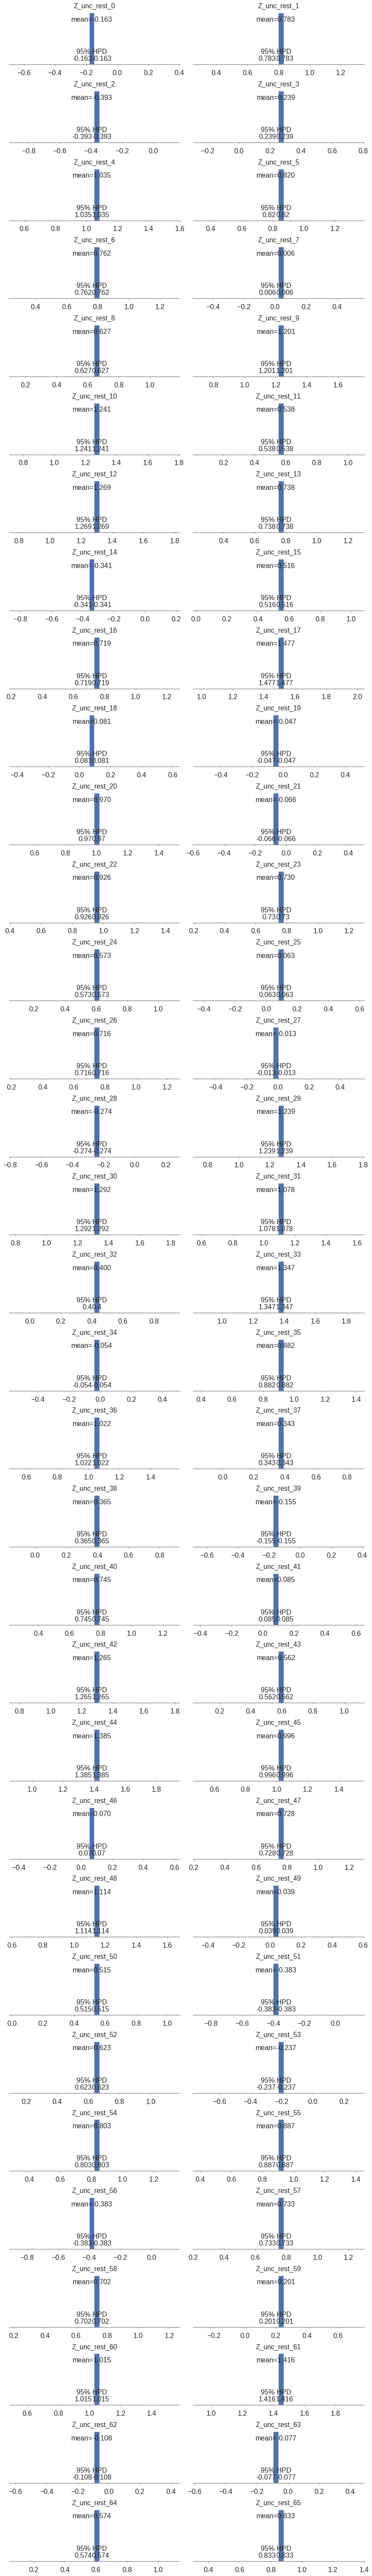

In [43]:
%matplotlib inline
pm.plot_posterior(trace, varnames=['Z_unc_rest'])

In [44]:
trace.get_values('GemPy')[5] -  trace.get_values('GemPy')[15]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [61]:
import matplotlib.pyplot as plt
plt.imshow(trace.get_values('GemPy')[-10].reshape(50,50), cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000] )
plt.colorbar()

ValueError: total size of new array must be unchanged

In [ ]:
import matplotlib.pyplot as plt
for i in range(100):
    gp.plot_section(geo_data, trace.get_values('GemPy')[i][0, :], 18,
                       direction='y', plot_data=False)
    plt.show()

In [ ]:
from theano.printing import pydotprint

pydotprint(model.logpt)